In [1]:
from typing import List

import empyrical as ep
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from data_service import get_index_daily, get_sales_depart_billboard
from matplotlib.ticker import MultipleLocator
from scr import HMA, get_forward_returns
from scr.plotting import plot_indicator, plot_quantile_group_ret
from scr.tushare_api import TuShare

my_ts = TuShare()

# 数据准备

In [3]:
# 数据获取
billboard_df: pd.DataFrame = get_sales_depart_billboard(
    '2013-01-01', '2021-12-31')

# 数据储存
billboard_df.to_csv('../data/billboard.csv', encoding='utf-8')

机构龙虎榜数据获取:   0%|          | 0/2188 [00:00<?, ?it/s]

In [2]:
# 读取本地文件
billboard_df: pd.DataFrame = pd.read_csv('../data/billboard.csv',
                                         encoding='utf-8',
                                         index_col=[0],
                                         parse_dates=['trade_date'])

In [3]:
# 获取沪深300数据
hs300:pd.DataFrame = get_index_daily(code='000300.SH',start_date = '20130101',end_date='20220222')

In [17]:
# 查看数据结构
hs300.head()

,code,close,open,high,low,pre_close,change,pct_chg,vol,amount
trade_date,,,,,,,,,,
2013-01-04,000300.SH,2524.409,2551.814,2558.529,2498.892,2522.952,1.457,0.0577,97988182.0,9.557925e+07
2013-01-07,000300.SH,2535.985,2518.047,2545.969,2511.603,2524.409,11.576,0.4586,75167993.0,7.316751e+07
2013-01-08,000300.SH,2525.330,2534.647,2540.513,2502.490,2535.985,-10.655,-0.4202,71837100.0,7.649806e+07
2013-01-09,000300.SH,2526.126,2518.104,2534.239,2504.299,2525.330,0.796,0.0315,70231170.0,7.423360e+07
2013-01-10,000300.SH,2530.569,2525.590,2553.352,2513.729,2526.126,4.443,0.1759,71085862.0,7.115905e+07


In [16]:
# 查看数据结构
billboard_df.head()

,trade_date,ts_code,exalter,buy,buy_rate,sell,sell_rate,net_buy,side,reason
0,2013-01-04,000043.SZ,中国国际金融有限公司上海淮海中路证券营业部,16970815.06,1.19,16377628.00,1.24,-593187.06,0,连续三个交易日内，涨幅偏离值累计达20%的证券
1,2013-01-04,000043.SZ,中国国际金融有限公司上海淮海中路证券营业部,16970815.06,1.19,16377628.00,1.24,-593187.06,1,连续三个交易日内，涨幅偏离值累计达20%的证券
2,2013-01-04,000043.SZ,中国国际金融有限公司深圳福华一路证券营业部,14052271.14,0.00,0.00,1.02,-14052271.14,1,连续三个交易日内，涨幅偏离值累计达20%的证券
3,2013-01-04,000043.SZ,中国银河证券股份有限公司绍兴证券营业部,5276763.48,1.13,15543450.07,0.38,10266686.59,0,连续三个交易日内，涨幅偏离值累计达20%的证券
4,2013-01-04,000043.SZ,光大证券股份有限公司深圳金田路证券营业部,3067442.00,2.02,27633247.70,0.22,24565805.70,0,连续三个交易日内，涨幅偏离值累计达20%的证券


# 特征构建

In [4]:
# 计算当日所有单个席位净流入金额(单个席位买入 金额-单个席位卖出金额)的总和
nextbuy: pd.Series = billboard_df.groupby('trade_date')['net_buy'].sum()

# IS_NetBuy/沪深 300 指数当日成交金额
is_netbuy_s: pd.Series = nextbuy / (hs300['amount'] * 1000)
is_netbuy_s: pd.Series = is_netbuy_s.dropna()

In [24]:
up_bound:pd.Series = is_netbuy_s.rolling(60).apply(lambda x:np.quantile(x,0.8))
low_bound:pd.Series = is_netbuy_s.rolling(60).apply(lambda x:np.quantile(x,0.15))

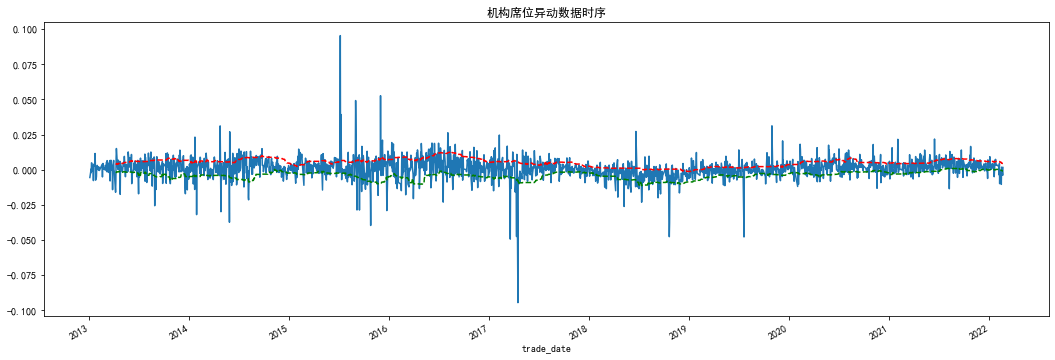

In [27]:
is_netbuy_s.plot(figsize=(18,6),title='机构席位异动数据时序')
up_bound.plot(color='red',ls='--')
low_bound.plot(color='g',ls='--');

In [26]:
quantile_indincator:pd.DataFrame = pd.concat((up_bound,is_netbuy_s,low_bound),axis=1)
quantile_indincator.columns = ['ub','signal','lb']

感觉并没有那么强的V型特征

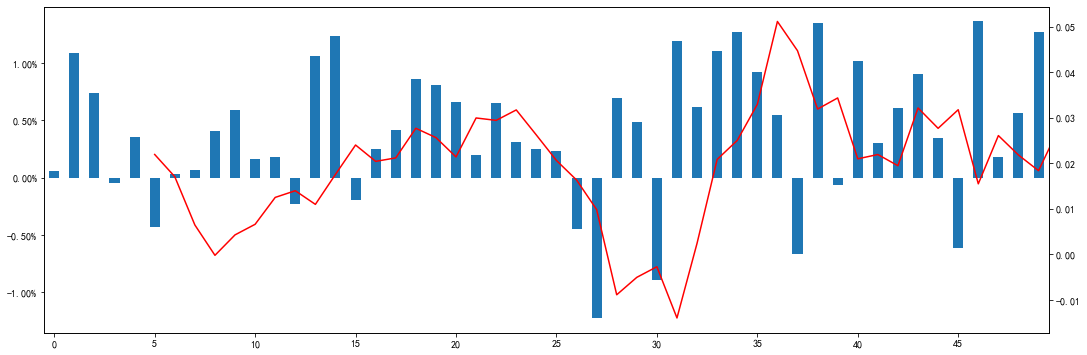

In [8]:
forward_returns: pd.Series = get_forward_returns(hs300['close'],
                                                 [3, 5, 10, 15, 20, 60])
# 根据特征分值分组
group = pd.qcut(is_netbuy_s,50,labels=False) + 1
group_ret = forward_returns.groupby(group)['10日收益'].mean()
# 画图
ax = group_ret.plot(kind='bar',figsize=(18,6))
group_ret.rolling(5).sum().plot(kind='line',color='red',secondary_y=True)
ax.yaxis.set_major_formatter('{x:.2%}')
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_major_formatter('{x:.0f}');

# 信号构建

In [16]:
# 计算HMA信号
is_netbuy_s_s:pd.Series = HMA(is_netbuy_s,30).dropna()
is_netbuy_s_l:pd.Series = HMA(is_netbuy_s,100).dropna()

In [17]:
# 数据对齐
netbuy_s_s,netbuy_s_l = is_netbuy_s_l.align(is_netbuy_s_s,join='left',axis=0)

In [18]:
indincator:pd.DataFrame = pd.concat((netbuy_s_s,netbuy_s_l),axis=1)
indincator.columns = ['fast','slow']

GridSpec(3, 1)

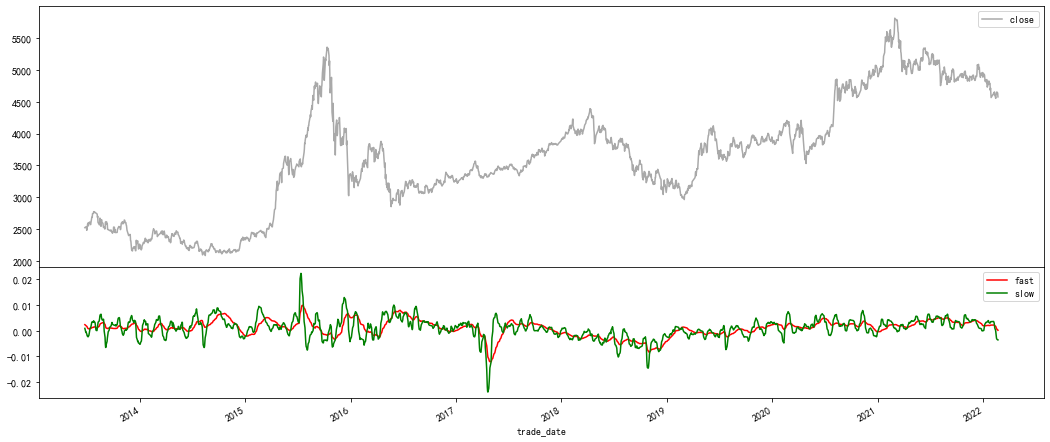

In [12]:
plot_indicator(hs300['close'],indincator)

# 回测

## 双均线策略

In [9]:
import datetime as dt

import backtrader as bt
from scr.bt_func import analysis_rets, analysis_trade, get_backtesting

In [14]:
class ma_cross(bt.Strategy):
    """策略逻辑:

    简单的双均线逻辑
    """
    def log(self, txt: str, current_dt: dt.datetime = None) -> None:

        current_dt = current_dt or self.datas[0].datetime.date(0)
        print('%s,%s' % (current_dt.isoformat(), txt))

    def __init__(self) -> None:

        self.order = None
        self.to_buy = bt.indicators.CrossOver(self.data0.lines.fast,self.data0.lines.slow)
        self.to_sell = bt.indicators.CrossOver(self.data0.lines.slow,self.data0.lines.fast)
        
    def next(self):
        # 取消之前未执行的订单
        if self.order:
            self.cancel(self.order)

        # 检查是否有持仓
        if not self.position:
            # vix下穿下轨,买入
            if self.to_buy > 0:
                # 全仓买入
                self.order = self.order_target_percent(target=0.9)
        # vix上穿上轨,卖出
        elif self.to_sell < 0:
            # 平仓
            self.order = self.close()


    def notify_order(self, order) -> None:

        # 未被处理得订单
        if order.status in [order.Submitted, order.Accepted]:

            return

        if order.status in [order.Completed, order.Canceled, order.Margin]:
            if order.isbuy():
                # buy
                self.log(
                    'BUY EXECUTED,ref:%.0f,Price:%.4f,Size:%.2f,Cost:%.4f,Comm %.4f,Stock:%s'
                    % (order.ref, order.executed.price, order.executed.size,
                       order.executed.value, order.executed.comm,
                       order.data._name))

            else:
                # sell
                self.log(
                    'SELL EXECUTED,ref:%.0f,Price:%.4f,Size:%.2f,Cost:%.4f,Comm %.4f,Stock:%s'
                    % (order.ref, order.executed.price, order.executed.size,
                       order.executed.value, order.executed.comm,
                       order.data._name))

In [15]:
bt_data:pd.DataFrame = hs300[['close','open','high','low','vol']].copy()
bt_data.rename(columns={'vol':'volume'},inplace=True)
bt_data['openinterest'] = 0
bt_data = pd.concat((bt_data,indincator),axis=1).dropna()

In [17]:
bt_result = get_backtesting(bt_data,'hs300',ma_cross)

2013-08-02,BUY EXECUTED,ref:1,Price:2263.7213,Size:40.00,Cost:90548.8540,Comm 0.0000,Stock:hs300
2013-08-30,SELL EXECUTED,ref:2,Price:2315.6814,Size:-40.00,Cost:90548.8540,Comm 0.0000,Stock:hs300
2013-10-28,BUY EXECUTED,ref:3,Price:2372.8083,Size:38.00,Cost:90166.7138,Comm 0.0000,Stock:hs300
2013-12-19,SELL EXECUTED,ref:4,Price:2365.9684,Size:-38.00,Cost:90166.7138,Comm 0.0000,Stock:hs300
2014-02-07,BUY EXECUTED,ref:5,Price:2187.5617,Size:41.00,Cost:89690.0311,Comm 0.0000,Stock:hs300
2014-03-17,SELL EXECUTED,ref:6,Price:2132.5797,Size:-41.00,Cost:89690.0311,Comm 0.0000,Stock:hs300
2014-05-05,BUY EXECUTED,ref:7,Price:2152.8053,Size:41.00,Cost:88265.0156,Comm 0.0000,Stock:hs300
2014-05-20,SELL EXECUTED,ref:8,Price:2124.4955,Size:-41.00,Cost:88265.0156,Comm 0.0000,Stock:hs300
2014-05-30,BUY EXECUTED,ref:9,Price:2156.5966,Size:41.00,Cost:88420.4622,Comm 0.0000,Stock:hs300
2014-07-24,SELL EXECUTED,ref:10,Price:2199.8330,Size:-41.00,Cost:88420.4622,Comm 0.0000,Stock:hs300
2014-10-10,BUY EXEC

,年化收益率,累计收益,波动率,夏普,最大回撤,索提诺比率,Calmar
策略,8.27%,94.41%,14.43%,62.30%,-25.87%,87.20%,31.96%
基准,9.31%,110.67%,22.79%,50.56%,-46.70%,69.58%,19.94%


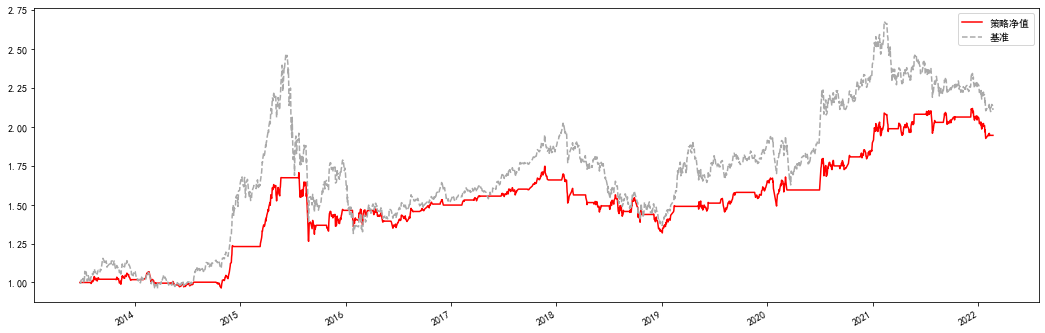

In [18]:
analysis_rets(bt_data['close'],bt_result.result)

## 百分位

In [10]:
class add_quantile_data(bt.feeds.PandasData):
    
    """用于加载回测用数据

    添加信号数据
    """
    lines = (
        'ub',
        'signal',
        'lb',
    )

    params = (('ub', -1), ('signal', -1), ('lb', -1))


class quantile_bound_strategy(bt.Strategy):
    """百分位上下轨策略

    当下穿下轨时开仓,上穿上轨时平仓
    signal,ub,lb提前加载到数据中
    """

    def log(self, txt: str, current_dt: dt.datetime = None) -> None:

        current_dt = current_dt or self.datas[0].datetime.date(0)
        print('%s,%s' % (current_dt.isoformat(), txt))

    def __init__(self) -> None:
        # print('signal', self.data0.lines.signal)
        # 开仓信号
        # if上穿则1,否则为-1
        self.open_signal = bt.indicators.CrossOver(self.data0.lines.lb,
                                                   self.data0.lines.signal)
        # 平仓信号
        self.close_signal = bt.indicators.CrossOver(self.data0.lines.signal,
                                                    self.data0.lines.ub)

        self.order = None

    def next(self):
        # 取消之前未执行的订单
        if self.order:
            self.cancel(self.order)

        # 检查是否有持仓
        if not self.position:
            # vix下穿下轨,买入
            if self.open_signal > 0:
                # 全仓买入
                self.order = self.order_target_percent(target=0.9)
        # vix上穿上轨,卖出
        elif self.close_signal < 0:
            # 平仓
            self.order = self.close()

    def notify_order(self, order) -> None:

        # 未被处理得订单
        if order.status in [order.Submitted, order.Accepted]:

            return

        if order.status in [order.Completed, order.Canceled, order.Margin]:
            if order.isbuy():
                # buy
                self.log(
                    'BUY EXECUTED,ref:%.0f,Price:%.4f,Size:%.2f,Cost:%.4f,Comm %.4f,Stock:%s'
                    % (order.ref, order.executed.price, order.executed.size,
                       order.executed.value, order.executed.comm,
                       order.data._name))

            else:
                # sell
                self.log(
                    'SELL EXECUTED,ref:%.0f,Price:%.4f,Size:%.2f,Cost:%.4f,Comm %.4f,Stock:%s'
                    % (order.ref, order.executed.price, order.executed.size,
                       order.executed.value, order.executed.comm,
                       order.data._name))

In [28]:
bt_data1:pd.DataFrame = hs300[['close','open','high','low','vol']].copy()
bt_data1.rename(columns={'vol':'volume'},inplace=True)
bt_data1['openinterest'] = 0
bt_data1 = pd.concat((bt_data1,quantile_indincator),axis=1).dropna()

In [29]:
bt_result = get_backtesting(bt_data1,'hs300',quantile_bound_strategy,add_quantile_data)

2013-04-24,BUY EXECUTED,ref:347,Price:2453.0263,Size:36.00,Cost:88308.9460,Comm 0.0000,Stock:hs300
2013-04-26,SELL EXECUTED,ref:348,Price:2477.4762,Size:-36.00,Cost:88308.9460,Comm 0.0000,Stock:hs300
2013-05-15,BUY EXECUTED,ref:349,Price:2494.2174,Size:36.00,Cost:89791.8263,Comm 0.0000,Stock:hs300
2013-05-29,SELL EXECUTED,ref:350,Price:2648.6621,Size:-36.00,Cost:89791.8263,Comm 0.0000,Stock:hs300
2013-06-07,BUY EXECUTED,ref:351,Price:2527.1657,Size:37.00,Cost:93505.1306,Comm 0.0000,Stock:hs300
2013-07-02,SELL EXECUTED,ref:352,Price:2211.5818,Size:-37.00,Cost:93505.1306,Comm 0.0000,Stock:hs300
2013-07-05,BUY EXECUTED,ref:353,Price:2227.5727,Size:38.00,Cost:84647.7639,Comm 0.0000,Stock:hs300
2013-07-10,SELL EXECUTED,ref:354,Price:2162.8817,Size:-38.00,Cost:84647.7639,Comm 0.0000,Stock:hs300
2013-07-22,BUY EXECUTED,ref:355,Price:2170.3060,Size:37.00,Cost:80301.3223,Comm 0.0000,Stock:hs300
2013-07-26,SELL EXECUTED,ref:356,Price:2226.2064,Size:-37.00,Cost:80301.3223,Comm 0.0000,Stock:hs300


,年化收益率,累计收益,波动率,夏普,最大回撤,索提诺比率,Calmar
策略,4.32%,43.61%,14.46%,36.51%,-38.77%,49.42%,11.14%
基准,7.45%,85.02%,22.84%,42.97%,-46.70%,58.82%,15.95%


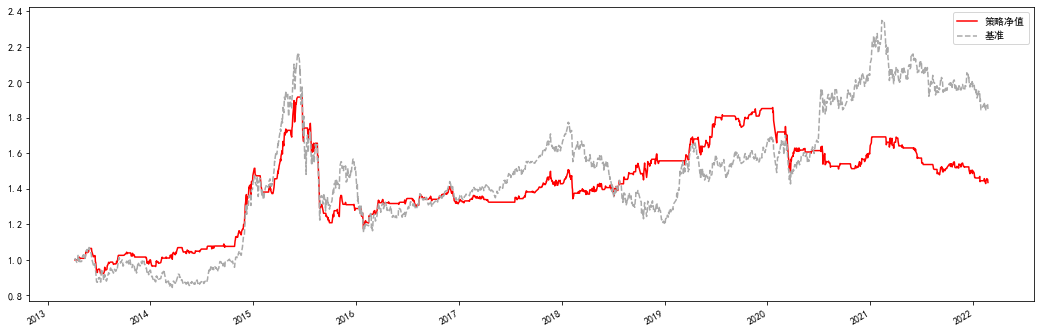

In [30]:
analysis_rets(bt_data1['close'],bt_result.result)